In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess

def normalize_model_class_name(model_class_name):
    line1 = model_class_name
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretClassifier_" , "caret.classifier.caret_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretRegressor_" , "caret.regressor.caret_reg_")
    line1 = line1.replace("sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor_" , "caret.preprocessor.caret_prep_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasClassifier_" , "keras.classifier.keras_class_")
    line1 = line1.replace("sklearn2sql.Helpers.Keras_Model.cKerasRegressor_" , "keras.regressor.keras_reg_")
    return line1

def normalize_model_name(model_name):
    line1 = model_name
    line1 = line1.replace("cCaretClassifier_" , "caret_class_")
    line1 = line1.replace("cCaretRegressor_" , "caret_reg_")
    line1 = line1.replace("cCaretPreprocessor_" , "caret_prep_")
    line1 = line1.replace("cKerasClassifier_" , "keras_class_")
    line1 = line1.replace("cKerasRegressor_" , "keras_reg_")
    return line1

database_name_from_dsn = {"pgsql" : "PostgreSQL",
                          "oracle" : "Oracle", 
                          "db2" : "IBM DB2", 
                          "sqltm" : "SQLite",
                          "mssql" : "MS SQL Server",
                          "mysql" : "MariaDB",
                          "hive" : "Apache Hive",
                          "impala" : "Impala",
                          "firebird" : "Firebird",
                          "monetdb" : "MonetDB",
                          "teradata" : "Teradata"}

def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

def truncate_error_message(x):
    lSpecialErrors = ['UnboundLocalError', 
                      'Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS', 
                      'Exception:CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL',
                      'cTrainingError:Exception:TRAIN_FAILED', 
                      'Exception:CHECK_MATERIALIZED_DATA_ERROR', 
                      'Exception:PREDICT_FAILED', 
                      'NAN_VALUE_ENCOUNTERED_IN_MODEL', 
                      'Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED', 
                      'Exception:CONNECTION_FAILED_WITH_ERROR',
                      'FileNotFoundError', 'IndexError', 'KeyError', 
                      'DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Invalid column/field name:', 
                      'cTrainingError']
    for lError in lSpecialErrors:
        if(lError in x):
            return lError + " ..."
    lLongMessages = ["concurrent transaction number is", 
                     "DOUBLE value is out of range in",
                     "Unexpected end of command" , 
                     "Token unknown"]
    for mess in lLongMessages:
        x = re.sub(mess + ".*$", mess + " ...", x) 
     
    x = re.sub("\(Background on this error at:.*\)", "", x) 
    x = re.sub("\[SQL.*$", "\[SQL ...", x) 
    return x[0:400]

def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = re.sub('^.*log:BENCH_STATUS ' , '',  line)
        # print(line1)
        fields = line1.split(" ")
        (lModel, lDatasetName, lDSN, lDialect, lDSNType) = fields[0:5]
        lStatus = " ".join(fields[5:-1])
        lTime = fields[-1][:-2]
        fields2 = lStatus.split(" ")
        lErrorMessage = " ".join(fields2[5:])
        status = fields2[4]

        sql_error = lErrorMessage
        
        
        row = [lModel, lDatasetName, lDialect, lDSN, status, lErrorMessage, lTime]
        if(False):
            print("[lModel]" , row[0])
            print("[lDatasetName]" , row[1])
            print("[lDialect]" , row[2])
            print("[lDSN]" , row[3])
            print("[status]" , row[4])
            print("[lErrorMessage]" , row[5])
            print("[lTime]" , row[6])
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['dialect'] = df['dialect'].apply(lambda x : strip_punc(x))
    df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
    df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
    df['status'] = df['status'].apply(lambda x : strip_punc(x))

    print(list( df['dialect'].unique()))
    df['dialect'] = df['dialect'].apply(database_name_from_dsn.get)
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['Model'] = df['Model'].apply(normalize_model_name)
    df['full_error_message'] = df['error_message']
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    df['error_message'] = df['error_message'].apply(truncate_error_message)
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

['db2', 'firebird', 'impala', 'monetdb', 'mssql', 'mysql', 'oracle', 'pgsql', 'sqltm', 'teradata']


In [5]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,12,"None),"
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),"
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,7,"None),"
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,15,"None),"
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,6,"None),"


In [6]:
df.Model.value_counts()

RandomForestClassifier_pipe         180
DummyClassifier                     180
LabelEncoder                        180
RidgeClassifierCV_pipe              180
Pipeline                            180
LabelBinarizer                      180
OneVsOneClassifier                  180
ExtraTreesClassifier_pipe           180
ExtraTreesClassifier                180
Perceptron_pipe                     180
Pipeline_pipe                       180
DummyClassifier_pipe                180
RidgeClassifierCV                   180
RandomForestClassifier              180
LinearSVC_pipe                      180
LinearSVC                           179
caret_class_rpart                   179
OneVsOneClassifier_pipe             179
Perceptron                          178
caret_class_rf                      178
caret_class_ctree                   178
RidgeClassifier                     177
PassiveAggressiveClassifier         177
keras_class_SimpleRNN_pipe          176
RidgeClassifier_pipe                176


In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        line1 = normalize_model_class_name(line1)
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'LGBMClassifier': 'lightgbm.sklearn.LGBMClassifier',
 'LGBMRegressor': 'lightgbm.sklearn.LGBMRegressor',
 'cCaretClassifier': 'sklearn2sql.Helpers.Caret_Model.cCaretClassifier',
 'caret_class_ctree': 'caret.classifier.caret_class_ctree',
 'caret_class_ctree2': 'caret.classifier.caret_class_ctree2',
 'caret_class_glm': 'caret.classifier.caret_class_glm',
 'caret_class_glmnet': 'caret.classifier.caret_class_glmnet',
 'caret_class_nnet': 'caret.classifier.caret_class_nnet',
 'caret_class_rf': 'caret.classifier.caret_class_rf',
 'caret_class_rpart': 'caret.classifier.caret_class_rpart',
 'caret_class_svmRadial': 'caret.classifier.caret_class_svmRadial',
 'caret_class_xgbTree': 'caret.classifier.caret_class_xgbTree',
 'cCaretPreprocessor': 'sklearn2sql.Helpers.Caret_Model.cCaretPreprocessor',
 'caret_prep_center_scale': 'caret.preprocessor.caret_prep_center_scale',
 'caret_prep_ica': 'caret.preprocessor.caret_prep_ica',
 'caret_prep_pca': 'caret.preprocessor.caret_prep_pca',
 'cCaretRegres

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,12,"None),",lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,7,"None),",lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,15,"None),",lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,6,"None),",lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, 'TIMEOUT', get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

['IBM DB2' 'Firebird' 'Impala' 'MonetDB' 'MS SQL Server' 'MariaDB'
 'Oracle' 'PostgreSQL' 'SQLite' 'Teradata']
df.shape (23240, 9) Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'full_error_message', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING Impala BernoulliNB 18 10
MODEL_DATASETS_MISSING Impala BernoulliNB_pipe 18 10
MODEL_DATASETS_MISSING Impala ComplementNB 18 10
MODEL_DATASETS_MISSING Impala ComplementNB_pipe 18 10
MODEL_DATASETS_MISSING Impala GradientBoostingClassifier 18 9
MODEL_DATASETS_MISSING Impala GradientBoostingClassifier_pipe 18 11
MODEL_DATASETS_MISSING Impala LGBMClassifier 18 11
MODEL_DATASETS_MISSING Impala LGBMClassifier_pipe 18 11
MODEL_DATASETS_MISSING Impala LinearDiscriminantAnalysis 18 13
MODEL_DATASETS_MISSING Impala LinearDiscriminantAnalysis_pipe 18 13
MODEL_DATASETS_MISSING Impala LogisticRegression 18 13
MODEL_DATASETS_MISSING Impala LogisticRegressionCV 18 13
MODEL_DATASETS_MISSING Impa

In [15]:
missing_data.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,caret_class_nnet,DS_BENCH_C_200_82_10_EA8E6ACF,Firebird,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier
1,caret_class_nnet,DS_BENCH_C_200_82_4_DBD3B4F4,Firebird,no_dsn,failure,TIMEOUT,None,TIMEOUT,caret.classifier
2,AdaBoostClassifier,DS_BENCH_C_200_82_10_EA8E6ACF,Impala,no_dsn,failure,TIMEOUT,None,TIMEOUT,sklearn.ensemble
3,AdaBoostClassifier,DS_BENCH_C_200_82_4_DBD3B4F4,Impala,no_dsn,failure,TIMEOUT,None,TIMEOUT,sklearn.ensemble
4,AdaBoostClassifier,DS_BENCH_C_50_82_10_EA8E6ACF,Impala,no_dsn,failure,TIMEOUT,None,TIMEOUT,sklearn.ensemble


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category


In [18]:
df.shape

(24237, 9)

In [19]:
df.dialect.value_counts()

Firebird         2424
MS SQL Server    2424
PostgreSQL       2424
MonetDB          2424
MariaDB          2424
SQLite           2424
Impala           2424
Oracle           2424
IBM DB2          2424
Teradata         2421
Name: dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['dialect'])['error_message'].value_counts())

In [22]:
df4 = msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)
df4.head(df4.shape[0])

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'error_message' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,,error_message
dialect,error_message,
Impala,TIMEOUT,372
Teradata,TIMEOUT,367
Firebird,"""DatabaseError:('Error while commiting transaction:\\n- SQLCODE: -913\\n- deadlock\\n- update conflicts with concurrent update\\n- concurrent transaction number is ...",189
MonetDB,TIMEOUT,156
Impala,Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED ...,141
MonetDB,Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED ...,141
Impala,DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Invalid column/field name: ...,116
Teradata,Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,99
Firebird,"'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while preparing SQL statement:\\n- SQLCODE: -902\\n- Dynamic SQL Error\\n- Too many Contexts of Relation/Procedure/Views. Maximum allowed is 256\', -902, 335544569) \[SQL ...",97


In [23]:
sorted(df.error_message.unique().tolist())

['"DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Exceeded the maximum depth of an expression tree (1000).\\n \\[SQL ...',
 '"DBAPIError:(impala.error.HiveServer2Error) NullPointerException: null\\n \\[SQL ...',
 '"DBAPIError:(impala.error.HiveServer2Error) OutOfMemoryError: GC overhead limit exceeded\\n \\[SQL ...',
 '"DatabaseError:(\'Error while commiting transaction:\\\\n- SQLCODE: -913\\\\n- deadlock\\\\n- update conflicts with concurrent update\\\\n- concurrent transaction number is ...',
 '"DatabaseError:(fdb.fbcore.DatabaseError) (\'Cursor.fetchone:\\\\n- SQLCODE: -802\\\\n- arithmetic exception, numeric overflow, or string truncation\\\\n- numeric value is out of range\', -802, 335544321) ,',
 '"DatabaseError:(fdb.fbcore.DatabaseError) (\'Cursor.fetchone:\\\\n- SQLCODE: -901\\\\n- Integer overflow.  The result of an integer operation caused the most significant bit of the result to carry.\', -901, 335544779) ,',
 '"DatabaseError:(teradata.api.DatabaseError) (106

In [24]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,20942
TIMEOUT,997
Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...,631
Exception:CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL ...,360
Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTED ...,282
"""DatabaseError:('Error while commiting transaction:\\n- SQLCODE: -913\\n- deadlock\\n- update conflicts with concurrent update\\n- concurrent transaction number is ...",189
DBAPIError:(impala.error.HiveServer2Error) AnalysisException: Invalid column/field name: ...,116
"'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while preparing SQL statement:\\n- SQLCODE: -902\\n- Dynamic SQL Error\\n- Too many Contexts of Relation/Procedure/Views. Maximum allowed is 256\', -902, 335544569) \[SQL ...",97
'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while preparing SQL statement:\\n- SQLCODE: -104\\n- Dynamic SQL Error\\n- SQL error code = -104\\n- Unexpected end of command ...,82
"'DatabaseError:(fdb.fbcore.DatabaseError) (\'Error while executing SQL statement:\\n- SQLCODE: -802\\n- arithmetic exception, numeric overflow, or string truncation\\n- numeric value is out of range\', -802, 335544321) \[SQL ...",63


In [25]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [26]:
#lGroupBy['rows'].describe()

In [27]:
lComparisonErrorMessage = '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS'
real_errors = df[df.error_message.str.contains(lComparisonErrorMessage)]
real_errors.Model.value_counts()

Series([], Name: Model, dtype: int64)

In [28]:
lNotImplementedMessage = 'CODE_GENERATION_NOT_IMPLEMENTED_FOR_MODEL'

not_impl_errors = df[df.error_message.str.contains(lNotImplementedMessage)]
not_impl_errors.Model.value_counts()


MiniBatchSparsePCA           120
SparsePCA                    120
LatentDirichletAllocation     60
NMF                           60
Name: Model, dtype: int64

In [29]:
# database related errors
def is_other_error(x):
    lKnownError = 'SUCCESS' in [x] or lComparisonErrorMessage in [x] or lNotImplementedMessage in [x]
    return not lKnownError

# other_errors = df.error_message.apply(lambda x : 1 if is_other_error(x)  else 0)
other_errors = df[df.error_message.apply(is_other_error)]
other_errors.Model.value_counts()


caret_class_svmRadial             128
SparsePCA                         120
MiniBatchSparsePCA                120
caret_class_nnet                  110
keras_class_SimpleRNN_pipe         95
keras_class_SimpleRNN              89
caret_class_xgbTree                85
keras_class_LSTM_pipe              79
keras_class_LSTM                   77
DummyClassifier_pipe               62
DummyClassifier                    61
NMF                                60
LatentDirichletAllocation          60
XGBClassifier_pipe                 52
ComplementNB_pipe                  51
ComplementNB                       50
SVC                                49
OrdinalEncoder                     49
caret_class_ctree2                 48
XGBClassifier                      48
keras_class_GRU_pipe               48
NuSVC                              46
SVC_pipe                           46
AdaBoostClassifier_pipe            46
keras_class_GRU                    46
NuSVC_pipe                         45
GaussianNB  

In [30]:
# df.pivot(index = 'Model', values='status' , columns='dialect')

In [31]:
df.columns

Index(['Model', 'dataset', 'dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'full_error_message', 'model_category'],
      dtype='object')

In [32]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,12,"None),",lightgbm.sklearn
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,3,"None),",lightgbm.sklearn
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,7,"None),",lightgbm.sklearn
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,15,"None),",lightgbm.sklearn
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",success,SUCCESS,6,"None),",lightgbm.sklearn


In [33]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [34]:

df = df[df['model_category'] != 'sklearn.dummy']
df = df[~df['error_message'].str.contains(lNotImplementedMessage)]



In [35]:
df.head()

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category,status_2
0,LGBMClassifier,DS_BENCH_C_200_22_10_D28EF166,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,12,"None),",lightgbm.sklearn,1
1,LGBMClassifier,DS_BENCH_C_200_22_2_2E64DEB6,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,3,"None),",lightgbm.sklearn,1
2,LGBMClassifier,DS_BENCH_C_200_22_4_9802FBBD,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,7,"None),",lightgbm.sklearn,1
3,LGBMClassifier,DS_BENCH_C_200_7_10_C3DE2F26,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,15,"None),",lightgbm.sklearn,1
4,LGBMClassifier,DS_BENCH_C_200_7_2_F2617B35,IBM DB2,"'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,6,"None),",lightgbm.sklearn,1


In [36]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                       \
dialect                       Firebird IBM DB2 Impala MS SQL Server MariaDB   
model_category                                                                
caret.classifier                   150     150    150           150     150   
caret.preprocessor                  36      36     36            36      36   
caret.regressor                     54      54     54            54      54   
keras.classifier                   144     144    144           144     144   
keras.regressor                     48      48     48            48      48   
lightgbm.sklearn                    48      48     48            48      48   
sklearn.calibration                 36      36     36            36      36   
sklearn.covariance                  12      12     12            12      12   
sklearn.decomposition               72      72     72            72      72   
sklearn.discriminant_analysis       36      36     36            36      36   
sklearn.ensemble                   252     252    252           252     252   
sklearn.feature_selection          108     108    108           108     108   
sklearn.impute                      24      24     24            24      24   
sklearn.kernel_ridge                12      12     12            12      12   
sklearn.linear_model               492     492    492           492     492   
sklearn.multiclass                  72      72     72            72      72   
sklearn.naive_bayes                144     144    144           144     144   
sklearn.neural_network              48      48     48            48      48   
sklearn.pipeline                    48      48     48            48      48   
sklearn.preprocessing              180     180    180           180     180   
sklearn.random_projection           24      24     24            24      24   
sklearn.svm                        156     156    156           156     156   
sklearn.tree                        96      96     96            96      96   
xgboost.sklearn                     48      48     48            48      48   
All                               2340    2340   2340          2340    2340   

                                                                                
dialect                       MonetDB Oracle PostgreSQL SQLite Teradata    All  
model_category                                                                  
caret.classifier                  150    150        150    150      150   1500  
caret.preprocessor                 36     36         36     36       36    360  
caret.regressor                    54     54         54     54       54    540  
keras.classifier                  144    144        144    144      144   1440  
keras.regressor                    48     48         48     48       48    480  
lightgbm.sklearn                   48     48         48     48       48    480  
sklearn.calibration                36     36         36     36       36    360  
sklearn.covariance                 12     12         12     12       12    120  
sklearn.decomposition              72     72         72     72       72    720  
sklearn.discriminant_analysis      36     36         36     36       36    360  
sklearn.ensemble                  252    252        252    252      252   2520  
sklearn.feature_selection         108    108        108    108      108   1080  
sklearn.impute                     24     24         24     24       24    240  
sklearn.kernel_ridge               12     12         12     12       12    120  
sklearn.linear_model              492    492        492    492      492   4920  
sklearn.multiclass                 72     72         72     72       72    720  
sklearn.naive_bayes               144    144        144    144      144   1440  
sklearn.neural_network             48     48         48     48       48    480  
sklearn.pipeline                   48     48         48     48       48    480  
sklearn.preprocessing             180   

In [37]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [38]:
pvt.head(pvt.shape[0])

mean                                    \
dialect                        Firebird   IBM DB2    Impala MS SQL Server   
model_category                                                              
caret.classifier               0.353333  0.166667  0.360000      0.226667   
caret.preprocessor             0.111111  0.000000  0.000000      0.027778   
caret.regressor                0.148148  0.000000  0.074074      0.111111   
keras.classifier               0.236111  0.090278  1.000000      0.236111   
keras.regressor                0.145833  0.062500  0.750000      0.041667   
lightgbm.sklearn               0.562500  0.020833  0.625000      0.000000   
sklearn.calibration            0.222222  0.000000  0.527778      0.000000   
sklearn.covariance             0.250000  0.166667  0.166667      0.166667   
sklearn.decomposition          0.222222  0.041667  0.222222      0.027778   
sklearn.discriminant_analysis  0.083333  0.055556  0.777778      0.027778   
sklearn.ensemble               0.392857  0.015873  0.376984      0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000      0.000000   
sklearn.impute                 0.000000  0.000000  0.000000      0.000000   
sklearn.kernel_ridge           0.750000  0.000000  0.000000      0.000000   
sklearn.linear_model           0.024390  0.002033  0.128049      0.002033   
sklearn.multiclass             0.458333  0.000000  0.416667      0.000000   
sklearn.naive_bayes            0.423611  0.041667  0.708333      0.027778   
sklearn.neural_network         0.375000  0.000000  0.458333      0.000000   
sklearn.pipeline               0.000000  0.000000  0.041667      0.000000   
sklearn.preprocessing          0.111111  0.088889  0.044444      0.033333   
sklearn.random_projection      0.166667  0.000000  0.000000      0.000000   
sklearn.svm                    0.525641  0.000000  0.294872      0.000000   
sklearn.tree                   0.000000  0.000000  0.041667      0.000000   
xgboost.sklearn                0.562500  0.020833  0.645833      0.020833   
All                            0.225641  0.032906  0.314530      0.041026   

                                                                        \
dialect                         MariaDB   MonetDB    Oracle PostgreSQL   
model_category                                                           
caret.classifier               0.193333  0.320000  0.220000   0.373333   
caret.preprocessor             0.000000  0.000000  0.000000   0.000000   
caret.regressor                0.111111  0.055556  0.000000   0.055556   
keras.classifier               0.236111  0.750000  0.097222   0.222222   
keras.regressor                0.020833  0.750000  0.062500   0.041667   
lightgbm.sklearn               0.020833  0.395833  0.020833   0.000000   
sklearn.calibration            0.000000  0.000000  0.000000   0.000000   
sklearn.covariance             0.166667  0.166667  0.083333   0.166667   
sklearn.decomposition          0.027778  0.194444  0.027778   0.027778   
sklearn.discriminant_analysis  0.055556  0.083333  0.055556   0.027778   
sklearn.ensemble               0.007937  0.091270  0.007937   0.007937   
sklearn.feature_selection      0.000000  0.000000  0.000000   0.000000   
sklearn.impute                 0.000000  0.000000  0.000000   0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000   0.000000   
sklearn.linear_model           0.002033  0.006098  0.002033   0.002033   
sklearn.multiclass             0.000000  0.000000  0.000000   0.000000   
sklearn.naive_bayes            0.027778  0.569444  0.027778   0.027778   
sklearn.neural_network         0.000000  0.333333  0.000000   0.000000   
sklearn.pipeline               0.000000  0.041667  0.000000   0.000000   
sklearn.preprocessing          0.033333  0.072222  0.033333   0.022222   
sklearn.random_projection      0.000000  0.000000  0.000000   0.000000   
sklearn.svm                    0.000000  0.064103  0.166667   0.000000   
sklearn.tree                

In [39]:
df.to_csv('report_extensive_tests.csv')

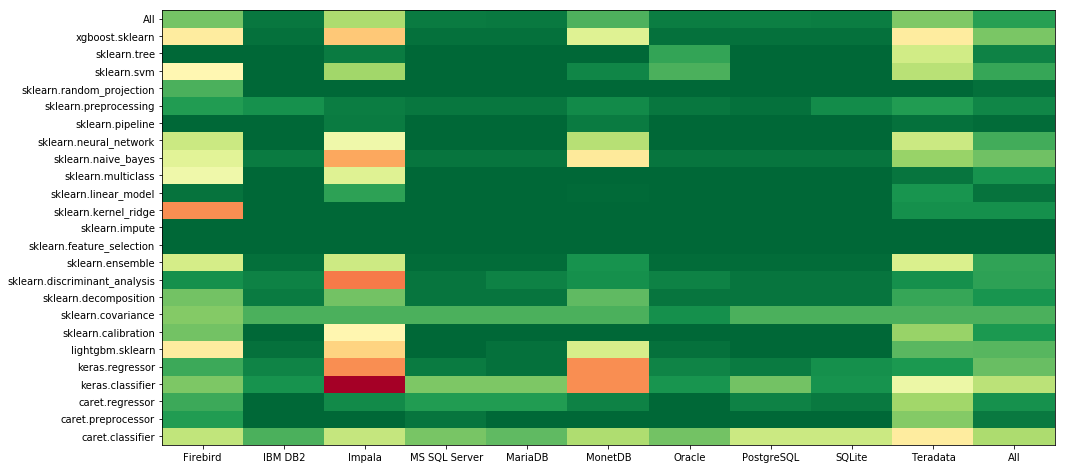

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn' , vmin=0 , vmax=1)
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [41]:
Category_Labels = df.model_category.unique()


In [42]:
Category_Labels

array(['lightgbm.sklearn', 'caret.classifier', 'caret.preprocessor',
       'caret.regressor', 'keras.classifier', 'keras.regressor',
       'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection', 'sklearn.impute',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.random_projection',
       'sklearn.svm', 'sklearn.tree', 'xgboost.sklearn'], dtype=object)

In [43]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:('Error while commiting transact...             21
              SUCCESS                                                        21
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              5
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Impala        TIMEOUT                                                        22
              SUCCESS                                                        18
              DBAPIError:(impala.error.HiveServer2Error) Anal...              8
MS SQL Server SUCCESS                                                        48
MariaDB       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MonetDB       SUCCESS                                                        29
              TIMEOUT                                                        15
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
Oracle        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
PostgreSQL    SUCCESS                                                        48
SQLite        SUCCESS                                                        48
Teradata      SUCCESS                                                        39
              'DatabaseError:(teradata.api.DatabaseError) (26...              5
              TIMEOUT                                                         2
              'DatabaseError:(teradata.api.DatabaseError) (37...              1
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1

mean                                              \
dialect              Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                       
LGBMClassifier       0.611111  0.000000  0.833333           0.0  0.000000   
LGBMClassifier_pipe  0.555556  0.055556  0.833333           0.0  0.055556   
LGBMRegressor        0.500000  0.000000  0.000000           0.0  0.000000   
LGBMRegressor_pipe   0.500000  0.000000  0.000000           0.0  0.000000   
All                  0.562500  0.020833  0.625000           0.0  0.020833   

                                                                               
dialect               MonetDB    Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                          
LGBMClassifier       0.555556  0.000000        0.0    0.0  0.222222  0.222222  
LGBMClassifier_pipe  0.500000  0.055556        0.0    0.0  0.222222  0.227778  
LGBMRegressor        0.000000  0.000000        0.0    0.0  0.000000  0.050000  
LGBMRegressor_pipe   0.000000  0.000000        0.0    0.0  0.166667  0.066667  
All                  0.395833  0.020833        0.0    0.0  0.187500  0.183333

ERROR_REPORT_FOR_CATEGORY caret.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        97
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             17
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              7
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              5
              "DatabaseError:('Error while commiting transact...              3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
              TIMEOUT                                                         2
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              FileNotFoundError ...                                           1
              IndexError ...                                                  1
IBM DB2       SUCCESS                                                       125
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                24
              UnboundLocalError ...                                           1
Impala        SUCCESS                                                        96
              TIMEOUT                                                        21
              DBAPIError:(impala.error.HiveServer2Error) Anal...             12
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                11
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     8
              IndexError ...                                                  1
              KeyError ...                                                    1
MS SQL Server SUCCESS                                                       116
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                24
              "OperationalError:(pymssql.OperationalError) (1...              8
              'OperationalError:(pymssql.OperationalError) (7...              2
MariaDB       SUCCESS                                                       121
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                25
              cTrainingError:Exception:TRAIN_FAILED ...                       4
MonetDB       SUCCESS                                                       102
              TIMEOUT                                                        20
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                18
              cTrainingError:Exception:TRAIN_FAILED ...                       5
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
              UnboundLocalError ...                                           1
Oracle        SUCCESS                                                       117
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                25
              cTrainingError:Exception:TRAIN_FAILED ...                       6
              TIMEOUT                                                         2
PostgreSQL    SUCCESS                                                        94
              TIMEOUT                                                        36
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                18
              cTrainingError:Exception:TRAIN_FAILED ...                       2
SQLite        SUCCESS                                                        94
              TIMEOUT                                                        36
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                18
              cTrainingError:Exception:TRAIN_FAILED ...                       2
Teradata      SUCCESS                                                        66
              Exception:CONNECTION_FAILED_WITH_ERROR ...                     28
              TIMEOUT                                             

mean                                              \
dialect                Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                         
caret_class_ctree      0.055556  0.000000  0.055556      0.000000  0.000000   
caret_class_ctree2     0.000000  0.000000  0.111111      0.000000  0.000000   
caret_class_glm        0.333333  0.000000  0.000000      0.000000  0.333333   
caret_class_glmnet     0.333333  0.000000  0.555556      0.111111  0.000000   
caret_class_nnet       0.722222  0.333333  0.666667      0.333333  0.333333   
caret_class_rf         0.055556  0.000000  0.388889      0.444444  0.055556   
caret_class_rpart      0.000000  0.000000  0.055556      0.000000  0.000000   
caret_class_svmRadial  0.944444  0.666667  0.666667      0.666667  0.666667   
caret_class_xgbTree    0.722222  0.388889  0.500000      0.333333  0.444444   
All                    0.353333  0.166667  0.360000      0.226667  0.193333   

                                                                          \
dialect                 MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                      
caret_class_ctree      0.000000  0.111111   0.000000  0.000000  0.555556   
caret_class_ctree2     0.000000  0.111111   1.000000  1.000000  0.444444   
caret_class_glm        0.333333  0.000000   0.333333  0.000000  0.500000   
caret_class_glmnet     0.388889  0.000000   0.000000  0.111111  0.611111   
caret_class_nnet       0.777778  0.333333   1.000000  1.000000  0.611111   
caret_class_rf         0.000000  0.111111   0.000000  0.000000  0.722222   
caret_class_rpart      0.000000  0.166667   0.000000  0.000000  0.111111   
caret_class_svmRadial  0.722222  0.666667   0.666667  0.666667  0.777778   
caret_class_xgbTree    0.666667  0.333333   0.333333  0.333333  0.666667   
All                    0.320000  0.220000   0.373333  0.373333  0.560000   

                                 
dialect                     All  
Model                            
caret_class_ctree      0.077778  
caret_class_ctree2     0.266667  
caret_class_glm        0.183333  
caret_class_glmnet     0.211111  
caret_class_nnet       0.611111  
caret_class_rf         0.177778  
caret_class_rpart      0.033333  
caret_class_svmRadial  0.711111  
caret_class_xgbTree    0.472222  
All                    0.314667

ERROR_REPORT_FOR_CATEGORY caret.preprocessor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        32
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
IBM DB2       SUCCESS                                                        36
Impala        SUCCESS                                                        36
MS SQL Server SUCCESS                                                        35
              Exception:PREDICT_FAILED ...                                    1
MariaDB       SUCCESS                                                        36
MonetDB       SUCCESS                                                        36
Oracle        SUCCESS                                                        36
PostgreSQL    SUCCESS                                                        36
SQLite        SUCCESS                                                        36
Teradata      SUCCESS                                                        27
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      8
              TIMEOUT                                                         1

mean                                       \
dialect                  Firebird IBM DB2 Impala MS SQL Server MariaDB   
Model                                                                    
caret_prep_center_scale  0.000000     0.0    0.0      0.083333     0.0   
caret_prep_ica           0.000000     0.0    0.0      0.000000     0.0   
caret_prep_pca           0.333333     0.0    0.0      0.000000     0.0   
All                      0.111111     0.0    0.0      0.027778     0.0   

                                                                              
dialect                 MonetDB Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                         
caret_prep_center_scale     0.0    0.0        0.0    0.0  0.666667  0.075000  
caret_prep_ica              0.0    0.0        0.0    0.0  0.000000  0.000000  
caret_prep_pca              0.0    0.0        0.0    0.0  0.083333  0.041667  
All                         0.0    0.0        0.0    0.0  0.250000  0.038889

ERROR_REPORT_FOR_CATEGORY caret.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        46
              "DatabaseError:('Error while commiting transact...              3
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
IBM DB2       SUCCESS                                                        54
Impala        SUCCESS                                                        50
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              "DBAPIError:(impala.error.HiveServer2Error) Nul...              1
              "DBAPIError:(impala.error.HiveServer2Error) Out...              1
MS SQL Server SUCCESS                                                        48
              "OperationalError:(pymssql.OperationalError) (1...              3
              cTrainingError:Exception:TRAIN_FAILED ...                       3
MariaDB       SUCCESS                                                        48
              cTrainingError:Exception:TRAIN_FAILED ...                       5
              KeyError ...                                                    1
MonetDB       SUCCESS                                                        51
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              1
              Exception:PREDICT_FAILED ...                                    1
              KeyError ...                                                    1
Oracle        SUCCESS                                                        54
PostgreSQL    SUCCESS                                                        51
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              Exception:PREDICT_FAILED ...                                    1
SQLite        SUCCESS                                                        52
              cTrainingError:Exception:TRAIN_FAILED ...                       2
Teradata      SUCCESS                                                        38
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      8
              'DatabaseError:(teradata.api.DatabaseError) (26...              2
              cTrainingError:Exception:TRAIN_FAILED ...                       2
              Exception:PREDICT_FAILED ...                                    1
              IndexError ...                                                  1
              KeyError ...                                                    1
              TIMEOUT                                                         1

mean                                            \
dialect              Firebird IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                     
caret_reg_ctree      0.000000     0.0  0.000000      0.000000  0.500000   
caret_reg_ctree2     0.000000     0.0  0.000000      0.000000  0.000000   
caret_reg_glm        0.000000     0.0  0.000000      0.000000  0.166667   
caret_reg_glmnet     0.000000     0.0  0.000000      0.500000  0.000000   
caret_reg_nnet       0.000000     0.0  0.000000      0.000000  0.000000   
caret_reg_rf         0.333333     0.0  0.000000      0.500000  0.333333   
caret_reg_rpart      0.000000     0.0  0.333333      0.000000  0.000000   
caret_reg_svmRadial  0.833333     0.0  0.333333      0.000000  0.000000   
caret_reg_xgbTree    0.166667     0.0  0.000000      0.000000  0.000000   
All                  0.148148     0.0  0.074074      0.111111  0.111111   

                                                                               
dialect               MonetDB Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                          
caret_reg_ctree      0.000000    0.0   0.000000  0.000000  1.000000  0.150000  
caret_reg_ctree2     0.000000    0.0   0.000000  0.000000  0.500000  0.050000  
caret_reg_glm        0.000000    0.0   0.000000  0.000000  0.000000  0.016667  
caret_reg_glmnet     0.166667    0.0   0.000000  0.333333  0.166667  0.116667  
caret_reg_nnet       0.000000    0.0   0.000000  0.000000  0.000000  0.000000  
caret_reg_rf         0.000000    0.0   0.000000  0.000000  0.833333  0.200000  
caret_reg_rpart      0.333333    0.0   0.000000  0.000000  0.000000  0.066667  
caret_reg_svmRadial  0.000000    0.0   0.000000  0.000000  0.166667  0.133333  
caret_reg_xgbTree    0.000000    0.0   0.500000  0.000000  0.000000  0.066667  
All                  0.055556    0.0   0.055556  0.037037  0.296296  0.088889

ERROR_REPORT_FOR_CATEGORY keras.classifier


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       110
              "DatabaseError:('Error while commiting transact...             21
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
IBM DB2       SUCCESS                                                       131
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Impala        Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...            107
              TIMEOUT                                                        36
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MS SQL Server SUCCESS                                                       110
              "OperationalError:(pymssql.OperationalError) (8...             20
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MariaDB       SUCCESS                                                       110
              'OperationalError:(_mysql_exceptions.Operationa...             20
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MonetDB       Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...            107
              SUCCESS                                                        36
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Oracle        SUCCESS                                                       130
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
PostgreSQL    SUCCESS                                                       112
              'DataError:(psycopg2.DataError) value out of ra...             13
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                13
              'DataError:(psycopg2.DataError) value out of ra...              5
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
SQLite        SUCCESS                                                       131
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
Teradata      SUCCESS                                                        79
              TIMEOUT                                                        56
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      2
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1

mean                                           \
dialect                     Firebird   IBM DB2 Impala MS SQL Server   MariaDB   
Model                                                                           
keras_class_Dense           0.055556  0.000000    1.0      0.000000  0.000000   
keras_class_Dense_pipe      0.166667  0.000000    1.0      0.000000  0.000000   
keras_class_GRU             0.111111  0.000000    1.0      0.000000  0.000000   
keras_class_GRU_pipe        0.166667  0.000000    1.0      0.000000  0.000000   
keras_class_LSTM            0.111111  0.055556    1.0      0.555556  0.555556   
keras_class_LSTM_pipe       0.166667  0.000000    1.0      0.611111  0.611111   
keras_class_SimpleRNN       0.500000  0.333333    1.0      0.333333  0.333333   
keras_class_SimpleRNN_pipe  0.611111  0.333333    1.0      0.388889  0.388889   
All                         0.236111  0.090278    1.0      0.236111  0.236111   

                                                                             \
dialect                    MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                         
keras_class_Dense             0.00  0.000000   0.000000  0.000000  0.388889   
keras_class_Dense_pipe        0.00  0.000000   0.000000  0.000000  0.555556   
keras_class_GRU               1.00  0.000000   0.000000  0.000000  0.444444   
keras_class_GRU_pipe          1.00  0.000000   0.000000  0.000000  0.500000   
keras_class_LSTM              1.00  0.055556   0.500000  0.055556  0.388889   
keras_class_LSTM_pipe         1.00  0.000000   0.555556  0.000000  0.444444   
keras_class_SimpleRNN         1.00  0.333333   0.333333  0.333333  0.444444   
keras_class_SimpleRNN_pipe    1.00  0.388889   0.388889  0.333333  0.444444   
All                           0.75  0.097222   0.222222  0.090278  0.451389   

                                      
dialect                          All  
Model                                 
keras_class_Dense           0.144444  
keras_class_Dense_pipe      0.172222  
keras_class_GRU             0.255556  
keras_class_GRU_pipe        0.266667  
keras_class_LSTM            0.427778  
keras_class_LSTM_pipe       0.438889  
keras_class_SimpleRNN       0.494444  
keras_class_SimpleRNN_pipe  0.527778  
All                         0.340972

ERROR_REPORT_FOR_CATEGORY keras.regressor


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        41
              "DatabaseError:('Error while commiting transact...              5
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
IBM DB2       SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Impala        Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...             34
              SUCCESS                                                        12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
MS SQL Server SUCCESS                                                        46
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
MariaDB       SUCCESS                                                        47
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              1
MonetDB       Exception:CODE_GENERATION_DATABASE_NOT_SUPPORTE...             34
              SUCCESS                                                        12
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
Oracle        SUCCESS                                                        45
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
PostgreSQL    SUCCESS                                                        46
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              2
SQLite        SUCCESS                                                        44
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              4
Teradata      SUCCESS                                                        43
              NAN_VALUE_ENCOUNTERED_IN_MODEL ...                              3
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      2

mean                                           \
dialect                   Firebird   IBM DB2 Impala MS SQL Server   MariaDB   
Model                                                                         
keras_reg_Dense           0.500000  0.000000   0.00      0.000000  0.000000   
keras_reg_Dense_pipe      0.000000  0.000000   0.00      0.000000  0.000000   
keras_reg_GRU             0.000000  0.000000   1.00      0.000000  0.000000   
keras_reg_GRU_pipe        0.166667  0.000000   1.00      0.000000  0.000000   
keras_reg_LSTM            0.166667  0.000000   1.00      0.000000  0.000000   
keras_reg_LSTM_pipe       0.000000  0.166667   1.00      0.000000  0.000000   
keras_reg_SimpleRNN       0.166667  0.166667   1.00      0.166667  0.000000   
keras_reg_SimpleRNN_pipe  0.166667  0.166667   1.00      0.166667  0.166667   
All                       0.145833  0.062500   0.75      0.041667  0.020833   

                                                                           \
dialect                  MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                       
keras_reg_Dense             0.00  0.000000   0.000000  0.000000  0.166667   
keras_reg_Dense_pipe        0.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU               1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_GRU_pipe          1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_LSTM              1.00  0.000000   0.000000  0.000000  0.166667   
keras_reg_LSTM_pipe         1.00  0.000000   0.000000  0.000000  0.000000   
keras_reg_SimpleRNN         1.00  0.333333   0.166667  0.500000  0.333333   
keras_reg_SimpleRNN_pipe    1.00  0.166667   0.166667  0.166667  0.166667   
All                         0.75  0.062500   0.041667  0.083333  0.104167   

                                    
dialect                        All  
Model                               
keras_reg_Dense           0.066667  
keras_reg_Dense_pipe      0.000000  
keras_reg_GRU             0.200000  
keras_reg_GRU_pipe        0.216667  
keras_reg_LSTM            0.233333  
keras_reg_LSTM_pipe       0.216667  
keras_reg_SimpleRNN       0.383333  
keras_reg_SimpleRNN_pipe  0.333333  
All                       0.206250

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        28
              "DatabaseError:('Error while commiting transact...              8
IBM DB2       SUCCESS                                                        36
Impala        SUCCESS                                                        17
              DBAPIError:(impala.error.HiveServer2Error) Anal...             12
              TIMEOUT                                                         5
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     2
MS SQL Server SUCCESS                                                        36
MariaDB       SUCCESS                                                        36
MonetDB       SUCCESS                                                        36
Oracle        SUCCESS                                                        36
PostgreSQL    SUCCESS                                                        36
SQLite        SUCCESS                                                        36
Teradata      SUCCESS                                                        26
              TIMEOUT                                                         8
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2

mean                                          \
dialect                      Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                           
CalibratedClassifierCV       0.222222     0.0  0.500000           0.0     0.0   
CalibratedClassifierCV_pipe  0.222222     0.0  0.555556           0.0     0.0   
All                          0.222222     0.0  0.527778           0.0     0.0   

                                                                        \
dialect                     MonetDB Oracle PostgreSQL SQLite  Teradata   
Model                                                                    
CalibratedClassifierCV          0.0    0.0        0.0    0.0  0.222222   
CalibratedClassifierCV_pipe     0.0    0.0        0.0    0.0  0.333333   
All                             0.0    0.0        0.0    0.0  0.277778   

                                       
dialect                           All  
Model                                  
CalibratedClassifierCV       0.094444  
CalibratedClassifierCV_pipe  0.111111  
All                          0.102778

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                         9
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
              "DatabaseError:('Error while commiting transact...              1
IBM DB2       SUCCESS                                                        10
              'InternalError:(ibm_db_dbi.InternalError) ibm_d...              2
Impala        SUCCESS                                                        10
              "DBAPIError:(impala.error.HiveServer2Error) Ana...              2
MS SQL Server SUCCESS                                                        10
              "OperationalError:(pymssql.OperationalError) (8...              2
MariaDB       SUCCESS                                                        10
              'OperationalError:(_mysql_exceptions.Operationa...              2
MonetDB       SUCCESS                                                        10
              TIMEOUT                                                         2
Oracle        SUCCESS                                                        11
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
PostgreSQL    SUCCESS                                                        10
              'OperationalError:(psycopg2.OperationalError) s...              2
SQLite        SUCCESS                                                        10
              'OperationalError:(sqlite3.OperationalError) Ex...              2
Teradata      SUCCESS                                                        10
              'DatabaseError:(teradata.api.DatabaseError) (38...              2

mean                                              \
dialect                Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                         
EllipticEnvelope       0.333333  0.333333  0.333333      0.333333  0.333333   
EllipticEnvelope_pipe  0.166667  0.000000  0.000000      0.000000  0.000000   
All                    0.250000  0.166667  0.166667      0.166667  0.166667   

                                                                          \
dialect                 MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                      
EllipticEnvelope       0.333333  0.166667   0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000   0.000000  0.000000  0.000000   
All                    0.166667  0.083333   0.166667  0.166667  0.166667   

                                 
dialect                     All  
Model                            
EllipticEnvelope       0.316667  
EllipticEnvelope_pipe  0.016667  
All                    0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        56
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             11
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                        69
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              'DBAPIError:(ibm_db_dbi.Error) ibm_db_dbi::Erro...              1
Impala        SUCCESS                                                        56
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                14
              TIMEOUT                                                         2
MS SQL Server SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MariaDB       SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                        58
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                14
Oracle        SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
SQLite        SUCCESS                                                        70
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Teradata      SUCCESS                                                        62
              TIMEOUT                                                         5
              'DatabaseError:(teradata.api.DatabaseError) (26...              3
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2

mean                                              \
dialect         Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                  
FactorAnalysis  0.000000  0.000000  0.000000      0.000000  0.000000   
FastICA         0.333333  0.166667  0.333333      0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.000000      0.000000  0.000000   
KernelPCA       1.000000  0.083333  1.000000      0.000000  0.000000   
PCA             0.000000  0.000000  0.000000      0.000000  0.000000   
TruncatedSVD    0.000000  0.000000  0.000000      0.000000  0.000000   
All             0.222222  0.041667  0.222222      0.027778  0.027778   

                                                                             
dialect          MonetDB    Oracle PostgreSQL    SQLite  Teradata       All  
Model                                                                        
FactorAnalysis  1.000000  0.000000   0.000000  0.000000  0.000000  0.100000  
FastICA         0.166667  0.166667   0.166667  0.166667  0.333333  0.216667  
IncrementalPCA  0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  
KernelPCA       0.000000  0.000000   0.000000  0.000000  0.500000  0.258333  
PCA             0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  
TruncatedSVD    0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  
All             0.194444  0.027778   0.027778  0.027778  0.138889  0.095833

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        33
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Impala        TIMEOUT                                                        26
              SUCCESS                                                         8
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MS SQL Server SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MariaDB       SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                        33
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              1
Oracle        SUCCESS                                                        34
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
SQLite        SUCCESS                                                        35
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Teradata      SUCCESS                                                        33
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                    \
dialect                          Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                         
LinearDiscriminantAnalysis       0.111111  0.000000  0.722222      0.000000   
LinearDiscriminantAnalysis_pipe  0.055556  0.111111  0.833333      0.055556   
All                              0.083333  0.055556  0.777778      0.027778   

                                                                          \
dialect                           MariaDB   MonetDB    Oracle PostgreSQL   
Model                                                                      
LinearDiscriminantAnalysis       0.000000  0.055556  0.000000   0.000000   
LinearDiscriminantAnalysis_pipe  0.111111  0.111111  0.111111   0.055556   
All                              0.055556  0.083333  0.055556   0.027778   

                                                               
dialect                            SQLite  Teradata       All  
Model                                                          
LinearDiscriminantAnalysis       0.000000  0.000000  0.088889  
LinearDiscriminantAnalysis_pipe  0.055556  0.166667  0.166667  
All                              0.027778  0.083333  0.127778

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       153
              "DatabaseError:('Error while commiting transact...             61
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             21
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              9
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              3
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                       248
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
              'ProgrammingError:(ibm_db_dbi.ProgrammingError)...              1
Impala        SUCCESS                                                       157
              DBAPIError:(impala.error.HiveServer2Error) Anal...             55
              TIMEOUT                                                        29
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     9
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MS SQL Server SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MariaDB       SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MonetDB       SUCCESS                                                       229
              TIMEOUT                                                        16
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              4
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
Oracle        SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
PostgreSQL    SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
SQLite        SUCCESS                                                       250
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
Teradata      SUCCESS                                                       150
              TIMEOUT                                                        49
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                43
              'DatabaseError:(teradata.api.DatabaseError) (26...              6
              'DatabaseError:(teradata.api.DatabaseError) (37...              3
              'DatabaseError:(teradata.api.DatabaseError) (38...              1

mean                                    \
dialect                          Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                         
AdaBoostClassifier               0.888889  0.000000  0.555556      0.000000   
AdaBoostClassifier_pipe          0.888889  0.055556  0.666667      0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000      0.000000   
AdaBoostRegressor_pipe           0.333333  0.000000  0.000000      0.000000   
BaggingClassifier                0.333333  0.000000  0.388889      0.000000   
BaggingClassifier_pipe           0.222222  0.000000  0.388889      0.000000   
BaggingRegressor                 0.666667  0.000000  0.000000      0.000000   
BaggingRegressor_pipe            0.333333  0.000000  0.000000      0.000000   
ExtraTreesClassifier             0.111111  0.000000  0.388889      0.000000   
ExtraTreesClassifier_pipe        0.277778  0.111111  0.500000      0.111111   
ExtraTreesRegressor              0.666667  0.000000  0.000000      0.000000   
ExtraTreesRegressor_pipe         0.166667  0.000000  0.000000      0.000000   
GradientBoostingClassifier       0.611111  0.000000  0.777778      0.000000   
GradientBoostingClassifier_pipe  0.611111  0.000000  0.833333      0.000000   
GradientBoostingRegressor        0.166667  0.000000  0.000000      0.000000   
GradientBoostingRegressor_pipe   0.166667  0.000000  0.000000      0.000000   
IsolationForest                  0.000000  0.000000  0.000000      0.000000   
IsolationForest_pipe             0.166667  0.166667  0.000000      0.000000   
RandomForestClassifier           0.222222  0.000000  0.388889      0.000000   
RandomForestClassifier_pipe      0.166667  0.000000  0.388889      0.000000   
RandomForestRegressor            0.666667  0.000000  0.000000      0.000000   
RandomForestRegressor_pipe       0.166667  0.000000  0.000000      0.000000   
All                              0.392857  0.015873  0.376984      0.007937   

                                                                          \
dialect                           MariaDB   MonetDB    Oracle PostgreSQL   
Model                                                                      
AdaBoostClassifier               0.000000  0.055556  0.000000   0.000000   
AdaBoostClassifier_pipe          0.000000  0.222222  0.000000   0.000000   
AdaBoostRegressor                0.000000  0.000000  0.000000   0.000000   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000   0.000000   
BaggingClassifier                0.000000  0.000000  0.000000   0.000000   
BaggingClassifier_pipe           0.000000  0.000000  0.000000   0.000000   
BaggingRegressor                 0.000000  0.000000  0.000000   0.000000   
BaggingRegressor_pipe            0.000000  0.000000  0.000000   0.000000   
ExtraTreesClassifier             0.000000  0.000000  0.000000   0.000000   
ExtraTreesClassifier_pipe        0.111111  0.111111  0.111111   0.111111   
ExtraTreesRegressor              0.000000  0.000000  0.000000   0.000000   
ExtraTreesRegressor_pipe         0.000000  0.000000  0.000000   0.000000   
GradientBoostingClassifier       0.000000  0.444444  0.000000   0.000000   
GradientBoostingClassifier_pipe  0.000000  0.444444  0.000000   0.000000   
GradientBoostingRegressor        0.000000  0.000000  0.000000   0.000000   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000   0.000000   
IsolationForest                  0.000000  0.000000  0.000000   0.000000   
IsolationForest_pipe             0.000000  0.000000  0.000000   0.000000   
RandomForestClassifier           0.000000  0.000000  0.000000   0.000000   
RandomForestClassifier_pipe      0.000000  0.000000  0.000000   0.000000   
RandomForestRegressor            0.000000  0.000000  0.000000   0.000000   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000   0.000000   
All                              0.007937  0.091270  0.007937   0.007937   

     

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


,,error_message
dialect,error_message,
Firebird,SUCCESS,108
IBM DB2,SUCCESS,108
Impala,SUCCESS,108
MS SQL Server,SUCCESS,108
MariaDB,SUCCESS,108
MonetDB,SUCCESS,108
Oracle,SUCCESS,108
PostgreSQL,SUCCESS,108
SQLite,SUCCESS,108


mean                                               \
dialect                 Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB   
Model                                                                           
GenericUnivariateSelect        0       0      0             0       0       0   
RFE                            0       0      0             0       0       0   
RFECV                          0       0      0             0       0       0   
SelectFdr                      0       0      0             0       0       0   
SelectFpr                      0       0      0             0       0       0   
SelectFromModel                0       0      0             0       0       0   
SelectFwe                      0       0      0             0       0       0   
SelectKBest                    0       0      0             0       0       0   
SelectPercentile               0       0      0             0       0       0   
All                            0       0      0             0       0       0   

                                                               
dialect                 Oracle PostgreSQL SQLite Teradata All  
Model                                                          
GenericUnivariateSelect      0          0      0        0   0  
RFE                          0          0      0        0   0  
RFECV                        0          0      0        0   0  
SelectFdr                    0          0      0        0   0  
SelectFpr                    0          0      0        0   0  
SelectFromModel              0          0      0        0   0  
SelectFwe                    0          0      0        0   0  
SelectKBest                  0          0      0        0   0  
SelectPercentile             0          0      0        0   0  
All                          0          0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.impute


,,error_message
dialect,error_message,
Firebird,SUCCESS,24
IBM DB2,SUCCESS,24
Impala,SUCCESS,24
MS SQL Server,SUCCESS,24
MariaDB,SUCCESS,24
MonetDB,SUCCESS,24
Oracle,SUCCESS,24
PostgreSQL,SUCCESS,24
SQLite,SUCCESS,24


mean                                                      \
dialect          Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB Oracle   
Model                                                                           
MissingIndicator        0       0      0             0       0       0      0   
SimpleImputer           0       0      0             0       0       0      0   
All                     0       0      0             0       0       0      0   

                                                 
dialect          PostgreSQL SQLite Teradata All  
Model                                            
MissingIndicator          0      0        0   0  
SimpleImputer             0      0        0   0  
All                       0      0        0   0

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              6
              SUCCESS                                                         3
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              2
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                        12
Impala        SUCCESS                                                        12
MS SQL Server SUCCESS                                                        12
MariaDB       SUCCESS                                                        12
MonetDB       SUCCESS                                                        12
Oracle        SUCCESS                                                        12
PostgreSQL    SUCCESS                                                        12
SQLite        SUCCESS                                                        12
Teradata      SUCCESS                                                        11
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                                      \
dialect          Firebird IBM DB2 Impala MS SQL Server MariaDB MonetDB Oracle   
Model                                                                           
KernelRidge          1.00     0.0    0.0           0.0     0.0     0.0    0.0   
KernelRidge_pipe     0.50     0.0    0.0           0.0     0.0     0.0    0.0   
All                  0.75     0.0    0.0           0.0     0.0     0.0    0.0   

                                                        
dialect          PostgreSQL SQLite  Teradata       All  
Model                                                   
KernelRidge             0.0    0.0  0.166667  0.116667  
KernelRidge_pipe        0.0    0.0  0.000000  0.050000  
All                     0.0    0.0  0.083333  0.083333

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       480
              "DatabaseError:('Error while commiting transact...              7
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
              cTrainingError ...                                              1
IBM DB2       SUCCESS                                                       491
              cTrainingError ...                                              1
Impala        SUCCESS                                                       429
              TIMEOUT                                                        52
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                    10
              cTrainingError ...                                              1
MS SQL Server SUCCESS                                                       491
              cTrainingError ...                                              1
MariaDB       SUCCESS                                                       491
              cTrainingError ...                                              1
MonetDB       SUCCESS                                                       489
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              1
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      1
              cTrainingError ...                                              1
Oracle        SUCCESS                                                       491
              cTrainingError ...                                              1
PostgreSQL    SUCCESS                                                       491
              cTrainingError ...                                              1
SQLite        SUCCESS                                                       491
              cTrainingError ...                                              1
Teradata      SUCCESS                                                       445
              TIMEOUT                                                        42
              'DatabaseError:(teradata.api.DatabaseError) (37...              4
              cTrainingError ...                                              1

mean                                    \
dialect                           Firebird   IBM DB2    Impala MS SQL Server   
Model                                                                          
ARDRegression                     0.000000  0.000000  0.000000      0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000      0.000000   
BayesianRidge                     0.000000  0.000000  0.000000      0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000      0.000000   
ElasticNet                        0.000000  0.000000  0.000000      0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000      0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000      0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000      0.000000   
Lars                              0.000000  0.000000  0.000000      0.000000   
LarsCV                            0.000000  0.000000  0.000000      0.000000   
LarsCV_pipe                       0.166667  0.000000  0.000000      0.000000   
Lars_pipe                         0.166667  0.000000  0.000000      0.000000   
Lasso                             0.000000  0.000000  0.000000      0.000000   
LassoCV                           0.000000  0.000000  0.000000      0.000000   
LassoCV_pipe                      0.000000  0.000000  0.000000      0.000000   
LassoLars                         0.000000  0.000000  0.000000      0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000      0.000000   
LassoLarsCV_pipe                  0.166667  0.000000  0.000000      0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000      0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000      0.000000   
LassoLars_pipe                    0.166667  0.000000  0.000000      0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000      0.000000   
LinearRegression                  0.000000  0.000000  0.000000      0.000000   
LinearRegression_pipe             0.166667  0.000000  0.000000      0.000000   
LogisticRegression                0.111111  0.000000  0.722222      0.000000   
LogisticRegressionCV              0.111111  0.000000  0.722222      0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.722222      0.000000   
LogisticRegression_pipe           0.000000  0.000000  0.722222      0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000      0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000      0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.055556      0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.055556      0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000      0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000      0.000000   
Perceptron                        0.000000  0.000000  0.055556      0.000000   
Perceptron_pipe                   0.055556  0.000000  0.055556      0.000000   
RANSACRegressor                   0.166667  0.166667  0.166667      0.166667   
RANSACRegressor_pipe              0.000000  0.000000  0.000000      0.000000   
Ridge                             0.000000  0.000000  0.000000      0.000000   
RidgeCV                           0.000000  0.000000  0.000000      0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000      0.000000   
RidgeClassifier                   0.000000  0.000000  0.055556      0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.055556      0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  0.055556      0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.055556      0.000000   
Ridge_pipe                        0.00

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        39
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             19
              "DatabaseError:('Error while commiting transact...             14
IBM DB2       SUCCESS                                                        72
Impala        SUCCESS                                                        42
              TIMEOUT                                                        13
              DBAPIError:(impala.error.HiveServer2Error) Anal...             12
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     4
              'DBAPIError:(impala.error.HiveServer2Error) Exe...              1
MS SQL Server SUCCESS                                                        72
MariaDB       SUCCESS                                                        72
MonetDB       SUCCESS                                                        72
Oracle        SUCCESS                                                        72
PostgreSQL    SUCCESS                                                        72
SQLite        SUCCESS                                                        72
Teradata      SUCCESS                                                        70
              'DatabaseError:(teradata.api.DatabaseError) (37...              2

mean                                          \
dialect                   Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                        
OneVsOneClassifier        0.500000     0.0  0.388889           0.0     0.0   
OneVsOneClassifier_pipe   0.444444     0.0  0.444444           0.0     0.0   
OneVsRestClassifier       0.388889     0.0  0.388889           0.0     0.0   
OneVsRestClassifier_pipe  0.500000     0.0  0.444444           0.0     0.0   
All                       0.458333     0.0  0.416667           0.0     0.0   

                                                                               
dialect                  MonetDB Oracle PostgreSQL SQLite  Teradata       All  
Model                                                                          
OneVsOneClassifier           0.0    0.0        0.0    0.0  0.000000  0.088889  
OneVsOneClassifier_pipe      0.0    0.0        0.0    0.0  0.055556  0.094444  
OneVsRestClassifier          0.0    0.0        0.0    0.0  0.000000  0.077778  
OneVsRestClassifier_pipe     0.0    0.0        0.0    0.0  0.055556  0.100000  
All                          0.0    0.0        0.0    0.0  0.027778  0.090278

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        83
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             42
              "DatabaseError:('Error while commiting transact...              7
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              7
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              1
IBM DB2       SUCCESS                                                       138
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              'DataError:(ibm_db_dbi.DataError) ibm_db_dbi::D...              2
Impala        TIMEOUT                                                        76
              SUCCESS                                                        42
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                    14
              DBAPIError:(impala.error.HiveServer2Error) Anal...             10
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 2
MS SQL Server SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
MariaDB       SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
MonetDB       TIMEOUT                                                        64
              SUCCESS                                                        62
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...             12
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      2
Oracle        SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
PostgreSQL    SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
SQLite        SUCCESS                                                       140
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4
Teradata      SUCCESS                                                       104
              TIMEOUT                                                        36
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 4

mean                                              \
dialect             Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                      
BernoulliNB         0.333333  0.000000  0.666667      0.000000  0.000000   
BernoulliNB_pipe    0.388889  0.000000  0.666667      0.000000  0.000000   
ComplementNB        0.500000  0.111111  0.722222      0.111111  0.111111   
ComplementNB_pipe   0.444444  0.111111  0.722222      0.111111  0.111111   
GaussianNB          0.500000  0.111111  0.777778      0.000000  0.000000   
GaussianNB_pipe     0.444444  0.000000  0.777778      0.000000  0.000000   
MultinomialNB       0.333333  0.000000  0.666667      0.000000  0.000000   
MultinomialNB_pipe  0.444444  0.000000  0.666667      0.000000  0.000000   
All                 0.423611  0.041667  0.708333      0.027778  0.027778   

                                                                       \
dialect              MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                   
BernoulliNB         0.500000  0.000000   0.000000  0.000000  0.388889   
BernoulliNB_pipe    0.500000  0.000000   0.000000  0.000000  0.388889   
ComplementNB        0.666667  0.111111   0.111111  0.111111  0.222222   
ComplementNB_pipe   0.666667  0.111111   0.111111  0.111111  0.333333   
GaussianNB          0.555556  0.000000   0.000000  0.000000  0.388889   
GaussianNB_pipe     0.555556  0.000000   0.000000  0.000000  0.277778   
MultinomialNB       0.555556  0.000000   0.000000  0.000000  0.111111   
MultinomialNB_pipe  0.555556  0.000000   0.000000  0.000000  0.111111   
All                 0.569444  0.027778   0.027778  0.027778  0.277778   

                              
dialect                  All  
Model                         
BernoulliNB         0.188889  
BernoulliNB_pipe    0.194444  
ComplementNB        0.277778  
ComplementNB_pipe   0.283333  
GaussianNB          0.233333  
GaussianNB_pipe     0.205556  
MultinomialNB       0.166667  
MultinomialNB_pipe  0.177778  
All                 0.215972

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        30
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             10
              "DatabaseError:('Error while commiting transact...              8
IBM DB2       SUCCESS                                                        48
Impala        SUCCESS                                                        26
              TIMEOUT                                                        22
MS SQL Server SUCCESS                                                        48
MariaDB       SUCCESS                                                        48
MonetDB       SUCCESS                                                        32
              TIMEOUT                                                        16
Oracle        SUCCESS                                                        48
PostgreSQL    SUCCESS                                                        48
SQLite        SUCCESS                                                        48
Teradata      SUCCESS                                                        30
              TIMEOUT                                                        18

mean                                          \
dialect             Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                  
MLPClassifier       0.555556     0.0  0.611111           0.0     0.0   
MLPClassifier_pipe  0.333333     0.0  0.611111           0.0     0.0   
MLPRegressor        0.166667     0.0  0.000000           0.0     0.0   
MLPRegressor_pipe   0.166667     0.0  0.000000           0.0     0.0   
All                 0.375000     0.0  0.458333           0.0     0.0   

                                                                          
dialect              MonetDB Oracle PostgreSQL SQLite Teradata       All  
Model                                                                     
MLPClassifier       0.444444    0.0        0.0    0.0    0.500  0.211111  
MLPClassifier_pipe  0.444444    0.0        0.0    0.0    0.500  0.188889  
MLPRegressor        0.000000    0.0        0.0    0.0    0.000  0.016667  
MLPRegressor_pipe   0.000000    0.0        0.0    0.0    0.000  0.016667  
All                 0.333333    0.0        0.0    0.0    0.375  0.154167

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        48
IBM DB2       SUCCESS                                                        48
Impala        SUCCESS                                                        46
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     2
MS SQL Server SUCCESS                                                        48
MariaDB       SUCCESS                                                        48
MonetDB       SUCCESS                                                        46
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              1
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      1
Oracle        SUCCESS                                                        48
PostgreSQL    SUCCESS                                                        48
SQLite        SUCCESS                                                        48
Teradata      SUCCESS                                                        47
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                                    \
dialect       Firebird IBM DB2    Impala MS SQL Server MariaDB   MonetDB   
Model                                                                      
FeatureUnion       0.0     0.0  0.000000           0.0     0.0  0.000000   
Pipeline           0.0     0.0  0.055556           0.0     0.0  0.055556   
Pipeline_pipe      0.0     0.0  0.055556           0.0     0.0  0.055556   
All                0.0     0.0  0.041667           0.0     0.0  0.041667   

                                                            
dialect       Oracle PostgreSQL SQLite  Teradata       All  
Model                                                       
FeatureUnion     0.0        0.0    0.0  0.000000  0.000000  
Pipeline         0.0        0.0    0.0  0.000000  0.011111  
Pipeline_pipe    0.0        0.0    0.0  0.055556  0.016667  
All              0.0        0.0    0.0  0.020833  0.010417

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                       160
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             15
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              2
IBM DB2       SUCCESS                                                       164
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 7
              'ProgrammingError:(ibm_db_dbi.ProgrammingError)...              5
              'DataError:(ibm_db_dbi.DataError) ibm_db_dbi::D...              4
Impala        SUCCESS                                                       172
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     2
MS SQL Server SUCCESS                                                       174
              "OperationalError:(pymssql.OperationalError) (1...              6
MariaDB       SUCCESS                                                       174
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
MonetDB       SUCCESS                                                       167
              'OperationalError:(pymonetdb.exceptions.Operati...             12
              TIMEOUT                                                         1
Oracle        SUCCESS                                                       174
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 6
PostgreSQL    SUCCESS                                                       176
              'OperationalError:(psycopg2.OperationalError) t...              4
SQLite        SUCCESS                                                       166
              'OperationalError:(sqlite3.OperationalError) pa...              6
              'OperationalError:(sqlite3.OperationalError) to...              4
              'OperationalError:(sqlite3.OperationalError) to...              4
Teradata      SUCCESS                                                       157
              TIMEOUT                                                        10
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 5
              "DatabaseError:(teradata.api.DatabaseError) (10...              4
              'DatabaseError:(teradata.api.DatabaseError) (56...              1

mean                                              \
dialect              Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                       
Binarizer            0.000000  0.000000  0.000000      0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000  0.000000      0.000000  0.000000   
LabelBinarizer       0.000000  0.000000  0.055556      0.000000  0.000000   
LabelEncoder         0.000000  0.000000  0.055556      0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
MinMaxScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
Normalizer           0.000000  0.000000  0.000000      0.000000  0.000000   
OneHotEncoder        0.000000  0.000000  0.000000      0.000000  0.000000   
OrdinalEncoder       0.500000  0.500000  0.500000      0.500000  0.500000   
PolynomialFeatures   0.333333  0.333333  0.000000      0.000000  0.000000   
PowerTransformer     0.000000  0.000000  0.000000      0.000000  0.000000   
QuantileTransformer  0.833333  0.500000  0.000000      0.000000  0.000000   
RobustScaler         0.000000  0.000000  0.000000      0.000000  0.000000   
StandardScaler       0.000000  0.000000  0.000000      0.000000  0.000000   
All                  0.111111  0.088889  0.044444      0.033333  0.033333   

                                                                        \
dialect               MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                    
Binarizer            0.000000  0.000000   0.000000  0.000000  0.000000   
KBinsDiscretizer     0.000000  0.000000   0.000000  0.000000  0.000000   
LabelBinarizer       0.000000  0.000000   0.000000  0.000000  0.000000   
LabelEncoder         0.000000  0.000000   0.000000  0.000000  0.000000   
MaxAbsScaler         0.000000  0.000000   0.000000  0.000000  0.000000   
MinMaxScaler         0.000000  0.000000   0.000000  0.000000  0.000000   
Normalizer           0.000000  0.000000   0.000000  0.000000  0.000000   
OneHotEncoder        0.000000  0.000000   0.000000  0.000000  0.000000   
OrdinalEncoder       0.083333  0.500000   0.000000  0.500000  0.500000   
PolynomialFeatures   0.000000  0.000000   0.333333  0.333333  0.333333   
PowerTransformer     1.000000  0.000000   0.000000  0.000000  0.000000   
QuantileTransformer  0.000000  0.000000   0.000000  0.333333  0.666667   
RobustScaler         0.000000  0.000000   0.000000  0.000000  0.166667   
StandardScaler       0.000000  0.000000   0.000000  0.000000  0.000000   
All                  0.072222  0.033333   0.022222  0.077778  0.112994   

                               
dialect                   All  
Model                          
Binarizer            0.000000  
KBinsDiscretizer     0.000000  
LabelBinarizer       0.005556  
LabelEncoder         0.005556  
MaxAbsScaler         0.000000  
MinMaxScaler         0.000000  
Normalizer           0.000000  
OneHotEncoder        0.000000  
OrdinalEncoder       0.408333  
PolynomialFeatures   0.166667  
PowerTransformer     0.100000  
QuantileTransformer  0.233333  
RobustScaler         0.016667  
StandardScaler       0.000000  
All                  0.062883

ERROR_REPORT_FOR_CATEGORY sklearn.random_projection


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        20
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              3
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...              1
IBM DB2       SUCCESS                                                        24
Impala        SUCCESS                                                        24
MS SQL Server SUCCESS                                                        24
MariaDB       SUCCESS                                                        24
MonetDB       SUCCESS                                                        24
Oracle        SUCCESS                                                        24
PostgreSQL    SUCCESS                                                        24
SQLite        SUCCESS                                                        24
Teradata      SUCCESS                                                        24

mean                                       \
dialect                   Firebird IBM DB2 Impala MS SQL Server MariaDB   
Model                                                                     
GaussianRandomProjection  0.333333     0.0    0.0           0.0     0.0   
SparseRandomProjection    0.000000     0.0    0.0           0.0     0.0   
All                       0.166667     0.0    0.0           0.0     0.0   

                                                                              
dialect                  MonetDB Oracle PostgreSQL SQLite Teradata       All  
Model                                                                         
GaussianRandomProjection     0.0    0.0        0.0    0.0      0.0  0.033333  
SparseRandomProjection       0.0    0.0        0.0    0.0      0.0  0.000000  
All                          0.0    0.0        0.0    0.0      0.0  0.016667

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
dialect       error_message                                                    
Firebird      SUCCESS                                                        74
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             32
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...             22
              "DatabaseError:(fdb.fbcore.DatabaseError) ('Cur...             21
              "DatabaseError:('Error while commiting transact...              7
IBM DB2       SUCCESS                                                       156
Impala        SUCCESS                                                       110
              TIMEOUT                                                        44
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                     2
MS SQL Server SUCCESS                                                       156
MariaDB       SUCCESS                                                       156
MonetDB       SUCCESS                                                       146
              TIMEOUT                                                         6
              'DBAPIError:(builtins.BrokenPipeError) [Errno 3...              3
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      1
Oracle        SUCCESS                                                       130
              TIMEOUT                                                        26
PostgreSQL    SUCCESS                                                       156
SQLite        SUCCESS                                                       156
Teradata      SUCCESS                                                       103
              TIMEOUT                                                        52
              'DatabaseError:(teradata.api.DatabaseError) (37...              1

mean                                                    \
dialect           Firebird IBM DB2    Impala MS SQL Server MariaDB   MonetDB   
Model                                                                          
LinearSVC         0.000000     0.0  0.055556           0.0     0.0  0.000000   
LinearSVC_pipe    0.000000     0.0  0.055556           0.0     0.0  0.000000   
LinearSVR         0.000000     0.0  0.000000           0.0     0.0  0.000000   
LinearSVR_pipe    0.000000     0.0  0.000000           0.0     0.0  0.000000   
NuSVC             0.777778     0.0  0.611111           0.0     0.0  0.111111   
NuSVC_pipe        0.833333     0.0  0.611111           0.0     0.0  0.055556   
NuSVR             1.000000     0.0  0.000000           0.0     0.0  0.333333   
NuSVR_pipe        0.166667     0.0  0.000000           0.0     0.0  0.333333   
OneClassSVM       0.833333     0.0  0.000000           0.0     0.0  0.000000   
OneClassSVM_pipe  0.166667     0.0  0.000000           0.0     0.0  0.000000   
SVC               0.888889     0.0  0.611111           0.0     0.0  0.111111   
SVC_pipe          0.833333     0.0  0.611111           0.0     0.0  0.055556   
SVR               1.000000     0.0  0.000000           0.0     0.0  0.000000   
SVR_pipe          0.500000     0.0  0.000000           0.0     0.0  0.000000   
All               0.525641     0.0  0.294872           0.0     0.0  0.064103   

                                                                  
dialect             Oracle PostgreSQL SQLite  Teradata       All  
Model                                                             
LinearSVC         0.000000        0.0    0.0  0.055556  0.011111  
LinearSVC_pipe    0.000000        0.0    0.0  0.055556  0.011111  
LinearSVR         0.000000        0.0    0.0  0.000000  0.000000  
LinearSVR_pipe    0.000000        0.0    0.0  0.000000  0.000000  
NuSVC             0.388889        0.0    0.0  0.666667  0.255556  
NuSVC_pipe        0.333333        0.0    0.0  0.666667  0.250000  
NuSVR             0.000000        0.0    0.0  0.000000  0.133333  
NuSVR_pipe        0.000000        0.0    0.0  0.000000  0.050000  
OneClassSVM       0.000000        0.0    0.0  0.000000  0.083333  
OneClassSVM_pipe  0.000000        0.0    0.0  0.000000  0.016667  
SVC               0.388889        0.0    0.0  0.722222  0.272222  
SVC_pipe          0.333333        0.0    0.0  0.722222  0.255556  
SVR               0.000000        0.0    0.0  0.166667  0.116667  
SVR_pipe          0.000000        0.0    0.0  0.000000  0.050000  
All               0.166667        0.0    0.0  0.339744  0.139103

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
dialect       error_message                                                 
Firebird      SUCCESS                                                     96
IBM DB2       SUCCESS                                                     96
Impala        SUCCESS                                                     92
              Exception:CHECK_MATERIALIZED_DATA_ERROR ...                  4
MS SQL Server SUCCESS                                                     96
MariaDB       SUCCESS                                                     96
MonetDB       SUCCESS                                                     96
Oracle        SUCCESS                                                     83
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...             13
PostgreSQL    SUCCESS                                                     96
SQLite        SUCCESS                                                     96
Teradata      SUCCESS                                                     59
              TIMEOUT                                                     37

mean                                          \
dialect                     Firebird IBM DB2    Impala MS SQL Server MariaDB   
Model                                                                          
DecisionTreeClassifier           0.0     0.0  0.055556           0.0     0.0   
DecisionTreeClassifier_pipe      0.0     0.0  0.055556           0.0     0.0   
DecisionTreeRegressor            0.0     0.0  0.000000           0.0     0.0   
DecisionTreeRegressor_pipe       0.0     0.0  0.000000           0.0     0.0   
ExtraTreeClassifier              0.0     0.0  0.055556           0.0     0.0   
ExtraTreeClassifier_pipe         0.0     0.0  0.055556           0.0     0.0   
ExtraTreeRegressor               0.0     0.0  0.000000           0.0     0.0   
ExtraTreeRegressor_pipe          0.0     0.0  0.000000           0.0     0.0   
All                              0.0     0.0  0.041667           0.0     0.0   

                                                                           \
dialect                     MonetDB    Oracle PostgreSQL SQLite  Teradata   
Model                                                                       
DecisionTreeClassifier          0.0  0.000000        0.0    0.0  0.500000   
DecisionTreeClassifier_pipe     0.0  0.000000        0.0    0.0  0.666667   
DecisionTreeRegressor           0.0  0.000000        0.0    0.0  0.000000   
DecisionTreeRegressor_pipe      0.0  0.000000        0.0    0.0  0.000000   
ExtraTreeClassifier             0.0  0.222222        0.0    0.0  0.333333   
ExtraTreeClassifier_pipe        0.0  0.500000        0.0    0.0  0.555556   
ExtraTreeRegressor              0.0  0.000000        0.0    0.0  0.000000   
ExtraTreeRegressor_pipe         0.0  0.000000        0.0    0.0  0.000000   
All                             0.0  0.135417        0.0    0.0  0.385417   

                                       
dialect                           All  
Model                                  
DecisionTreeClassifier       0.055556  
DecisionTreeClassifier_pipe  0.072222  
DecisionTreeRegressor        0.000000  
DecisionTreeRegressor_pipe   0.000000  
ExtraTreeClassifier          0.061111  
ExtraTreeClassifier_pipe     0.111111  
ExtraTreeRegressor           0.000000  
ExtraTreeRegressor_pipe      0.000000  
All                          0.056250

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
dialect       error_message                                                    
Firebird      "DatabaseError:('Error while commiting transact...             22
              SUCCESS                                                        21
              'DatabaseError:(fdb.fbcore.DatabaseError) (\'Er...              4
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
IBM DB2       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Impala        TIMEOUT                                                        24
              SUCCESS                                                        17
              DBAPIError:(impala.error.HiveServer2Error) Anal...              7
MS SQL Server SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MariaDB       SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
MonetDB       SUCCESS                                                        28
              TIMEOUT                                                        16
              Exception:CONNECTION_FAILED_WITH_ERROR ...                      3
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Oracle        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
PostgreSQL    SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
SQLite        SUCCESS                                                        47
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1
Teradata      TIMEOUT                                                        26
              SUCCESS                                                        21
              Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS ...                 1

mean                                              \
dialect             Firebird   IBM DB2    Impala MS SQL Server   MariaDB   
Model                                                                      
XGBClassifier       0.611111  0.000000  0.833333      0.000000  0.000000   
XGBClassifier_pipe  0.722222  0.000000  0.888889      0.000000  0.000000   
XGBRegressor        0.333333  0.166667  0.000000      0.166667  0.166667   
XGBRegressor_pipe   0.166667  0.000000  0.000000      0.000000  0.000000   
All                 0.562500  0.020833  0.645833      0.020833  0.020833   

                                                                       \
dialect              MonetDB    Oracle PostgreSQL    SQLite  Teradata   
Model                                                                   
XGBClassifier       0.500000  0.000000   0.000000  0.000000  0.722222   
XGBClassifier_pipe  0.555556  0.000000   0.000000  0.000000  0.722222   
XGBRegressor        0.166667  0.166667   0.166667  0.166667  0.166667   
XGBRegressor_pipe   0.000000  0.000000   0.000000  0.000000  0.000000   
All                 0.416667  0.020833   0.020833  0.020833  0.562500   

                              
dialect                  All  
Model                         
XGBClassifier       0.266667  
XGBClassifier_pipe  0.288889  
XGBRegressor        0.166667  
XGBRegressor_pipe   0.016667  
All                 0.231250

In [44]:
df[df.model_category == "bad_category"]

,Model,dataset,dialect,DSN,status,error_message,elapsed_time,full_error_message,model_category,status_2


IBM DB2


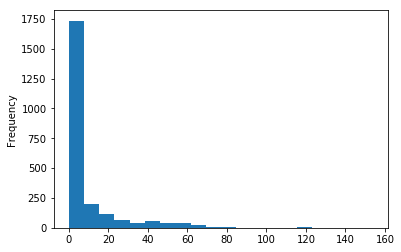

Firebird


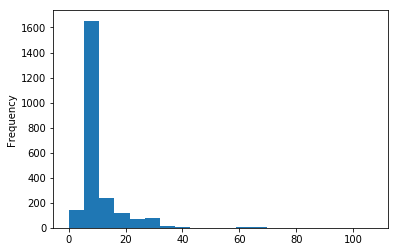

Impala


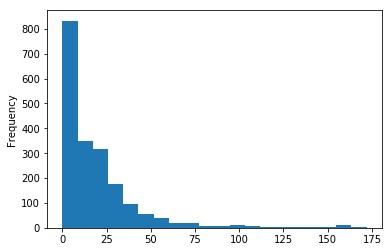

MonetDB


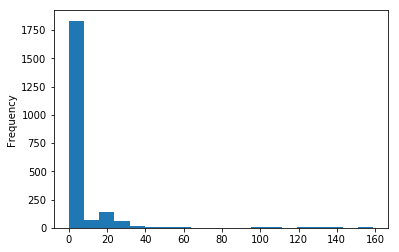

MS SQL Server


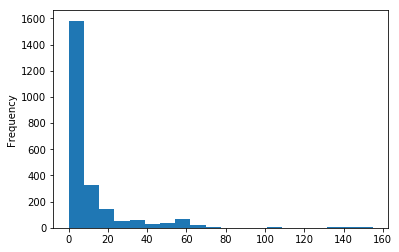

MariaDB


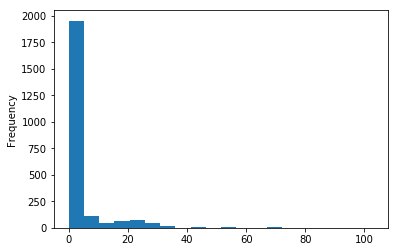

Oracle


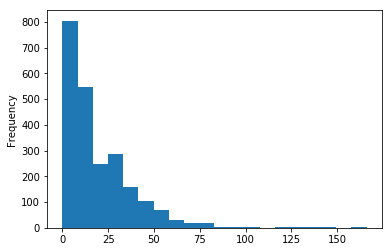

PostgreSQL


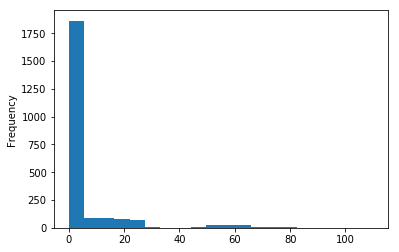

SQLite


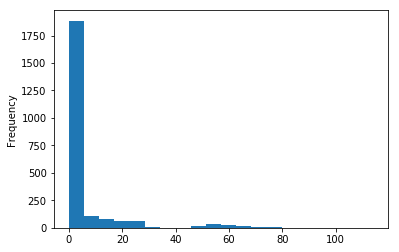

Teradata


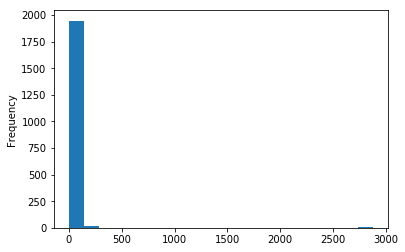

In [45]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
